Title - Implementation of GAN on any suitable dataset.



Generative Adversarial Networks (GANs) are a powerful class of artificial intelligence models used for generating new data that resembles a given dataset. GANs consist of two neural networks, the generator, and the discriminator, trained in an adversarial manner. The generator tries to create realistic samples from random noise, while the discriminator attempts to distinguish between real and generated data.

The provided Python code demonstrates a GAN implementation to generate handwritten digits using the MNIST dataset. The dataset contains images of digits from 0 to 9. The code uses TensorFlow and Keras libraries for building and training the GAN.

The GAN training starts by loading and preprocessing the MNIST dataset. Images are normalized to have pixel values between -1 and 1, and the generator is provided random noise as input to produce synthetic images. The discriminator takes both real and generated images as input and outputs a probability score indicating whether the input is real or fake.

The GAN model consists of two main components: the generator and the discriminator. The generator is a deep neural network that uses dense and convolutional layers to transform random noise into realistic images. The discriminator is another deep neural network that classifies whether an image is real (from the dataset) or fake (generated by the generator).

The GAN is trained using a two-step process called a "training step." In each training step, the generator and discriminator are updated based on their respective losses. The discriminator aims to minimize the binary cross-entropy loss between the predicted scores and the actual labels (1 for real images and 0 for fake images). The generator aims to generate realistic images to deceive the discriminator, so it tries to maximize the binary cross-entropy loss with the discriminator.

During training, the generator gradually improves at generating realistic images that resemble handwritten digits, while the discriminator gets better at distinguishing between real and fake images. The GAN's learning process is iterative and adversarial, where both networks improve and adapt to each other's strategies.

The GAN is trained for 50 epochs, and every 15 epochs, a set of generated images is saved and displayed. As the training progresses, the generated images become increasingly similar to real handwritten digits.

In conclusion, GANs have revolutionized the field of generative modeling and have been successfully applied to various domains, including image generation, text-to-image synthesis, and music generation. The Python code provided offers a hands-on implementation of a GAN for generating handwritten digits, showcasing the potential of GANs in creative data generation tasks. However, it is essential to keep in mind that GAN training can be challenging, requiring careful hyperparameter tuning and a balanced generator-discriminator architecture to achieve high-quality generated samples.

11490434/11490434 [==============================] - 0s 0us/step


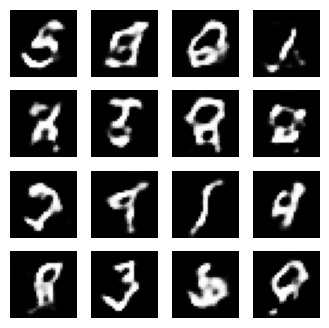

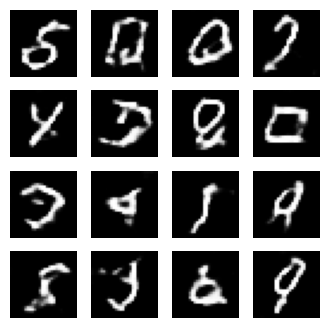

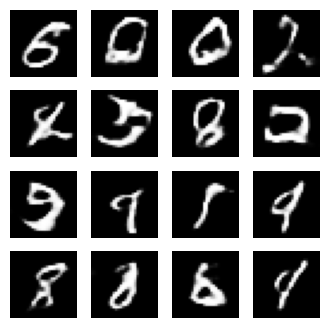

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape images
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Define GAN models
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define loss function and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

# Build GAN model
generator = build_generator()
discriminator = build_discriminator()

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Training loop
BATCH_SIZE = 128
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if (epoch + 1) % 15 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(BATCH_SIZE)

# Start training
train(train_dataset, EPOCHS)